# Прогнозирование уровня средней заработной платы в России

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [37]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from itertools import product
import warnings
import datetime
from dateutil.relativedelta import *
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [38]:
link_url = 'https://d3c33hcgiwev3.cloudfront.net/_6fe18044bab91a87a1b1f69bc528f1ea_WAG_C_M.csv?Expires=1645056000&Signature=anl3UZuG0~5OjB52IWUvFNgV578aM32SwLdsv~QSAeWiGo27lq03oJ6F0F-hku~yKFypDRhL-ygHiNhkhxBzimpf99B5rMgCY4aWxMBhGWHdjy~EecK90ZpGolh~FLxGPdo3gBotmfymzcqMkX54VHXwQp39WwvK7zcFsbfm9Ys_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A'

In [39]:
data = pd.read_csv(link_url, sep=';', parse_dates=['month'], dayfirst=True, index_col=['month'])
data

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


## Визуальный анализ ряда

<AxesSubplot:xlabel='month', ylabel='WAG_C_M'>

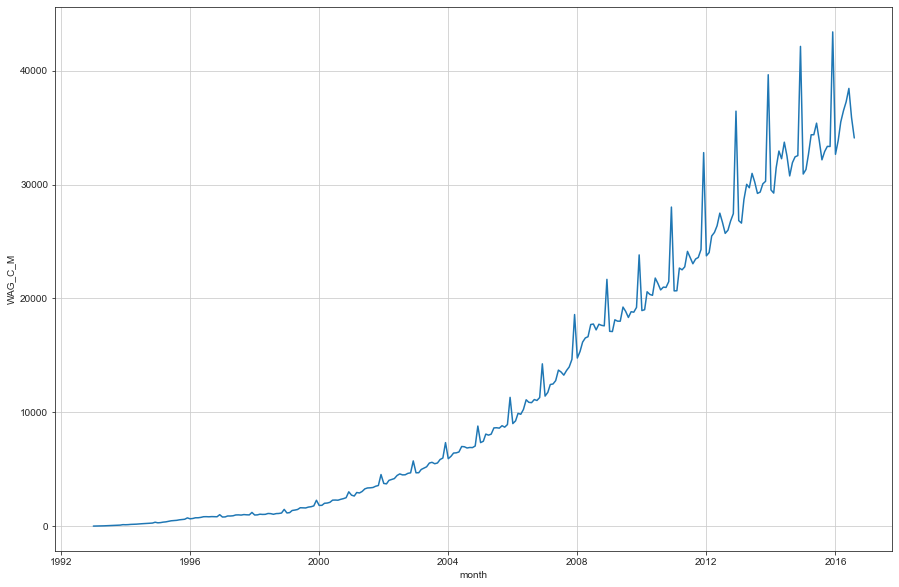

In [40]:
sns.set_style("ticks",{'axes.grid' : True})
sns.lineplot(x=data.index, y=data.WAG_C_M,figure=figsize(15, 10))

На графике чётко виден тренд, а так же сезонность. Так же с течением времени увеличивается дисперсия.

Проверка стационарности и STL-декомпозиция ряда:

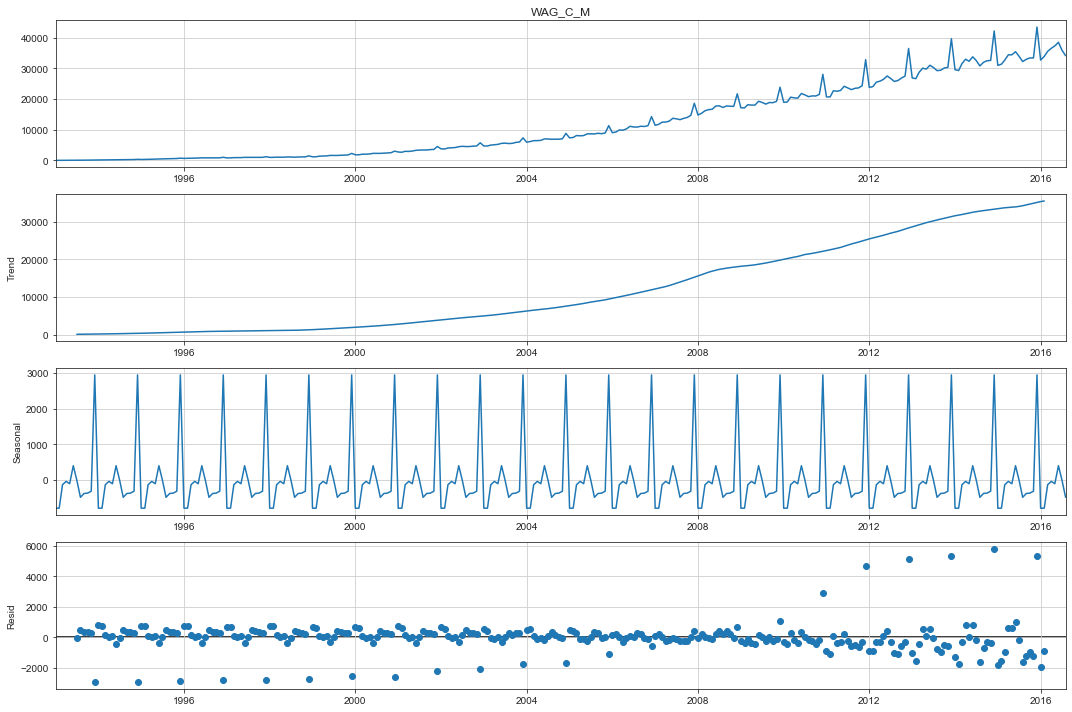

In [41]:
sm.tsa.seasonal_decompose(data.WAG_C_M).plot();

## Стабилизация дисперсии

In [42]:
data['WAG_C_M_boxed'], lmbda = stats.boxcox(data.WAG_C_M)

In [43]:
print(f'Оптимальный параметр преобразования Бокса-Кокса: {round(lmbda, 4)}')
print(f'Критерий Дики-Фуллера до стабилизации дисперсии: p={round(sm.tsa.stattools.adfuller(data.WAG_C_M)[1], 4)}')
print(f'Критерий Дики-Фуллера после стабилизации дисперсии: p={round(sm.tsa.stattools.adfuller(data.WAG_C_M_boxed)[1], 4)}')

Оптимальный параметр преобразования Бокса-Кокса: 0.2632
Критерий Дики-Фуллера до стабилизации дисперсии: p=0.9918
Критерий Дики-Фуллера после стабилизации дисперсии: p=0.6969


Преобразованный график после стабилизаци дисперсии:


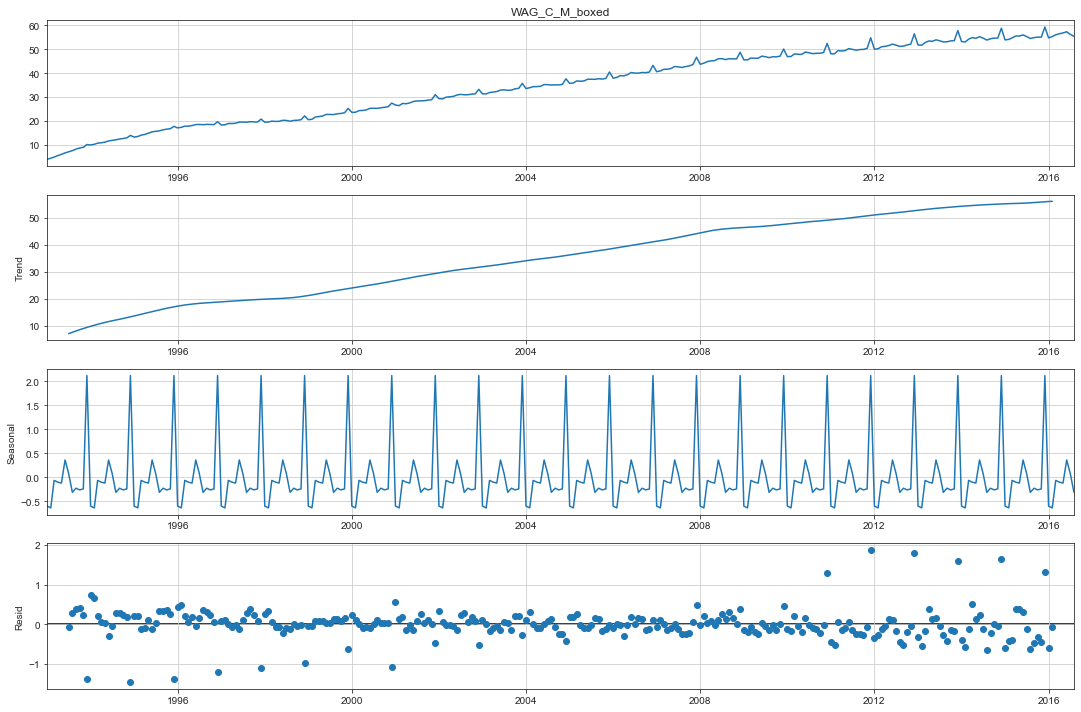

In [44]:
print('Преобразованный график после стабилизаци дисперсии:')
sm.tsa.seasonal_decompose(data.WAG_C_M_boxed).plot();

## Сезонное дифференцирование
Так как ряд ещё далеко не стационарен, применим сезонное дифференцирование и найдём критерий Дики-Фуллера для полученного ряда.

In [45]:
data['WAG_C_M_seasondiff'] = data.WAG_C_M_boxed - data.WAG_C_M_boxed.shift(12)

Преобразованный график после cезонного дифференцирования:


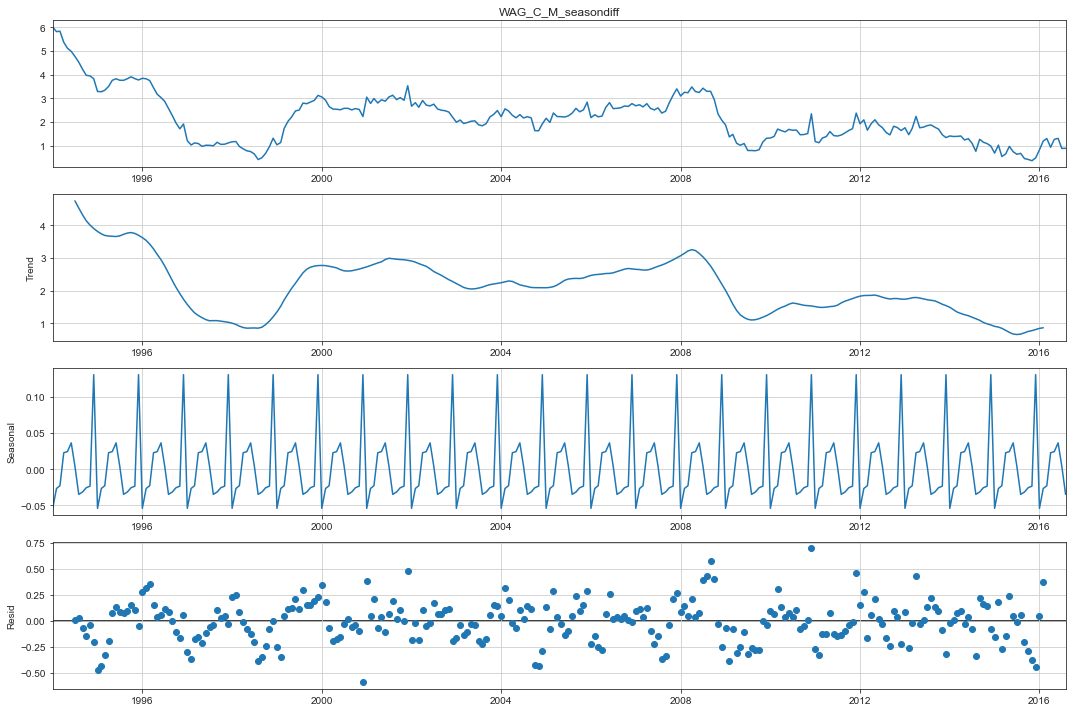

In [46]:
print('Преобразованный график после cезонного дифференцирования:')
sm.tsa.seasonal_decompose(data.WAG_C_M_seasondiff.dropna()).plot();

In [47]:
print(f'Критерий Дики-Фуллера после сезонного дифференцирования: p={round(sm.tsa.stattools.adfuller(data.WAG_C_M_seasondiff.dropna())[1], 4)}')

Критерий Дики-Фуллера после сезонного дифференцирования: p=0.0147


С таким значением критерия уже можно говорить о том, что ряд стационарен, но на графиках ещё видна какая-то структурированность, так что перейдём к простому дифференцированию.

## Обычное дифференцирование

In [48]:
data['WAG_C_M_diff'] = data.WAG_C_M_seasondiff - data.WAG_C_M_seasondiff.shift(1)

Преобразованный график после cезонного дифференцирования:


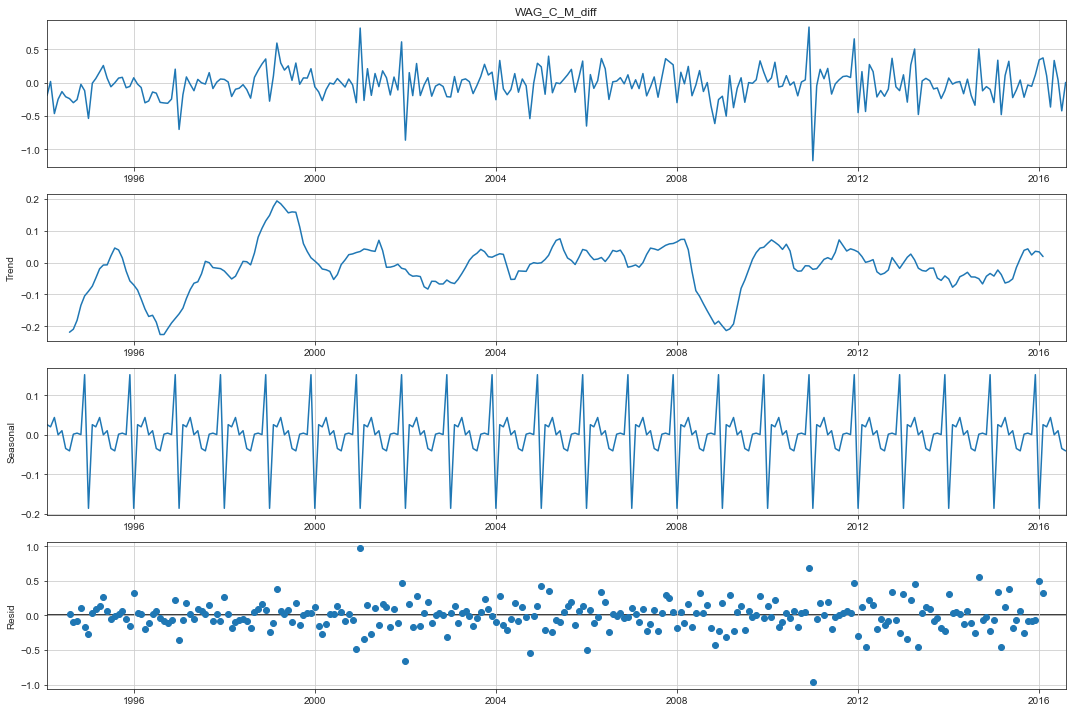

In [49]:
print('Преобразованный график после cезонного дифференцирования:')
sm.tsa.seasonal_decompose(data.WAG_C_M_diff.dropna()).plot();

In [50]:
print(f'Критерий Дики-Фуллера после дифференцирования: p={round(sm.tsa.stattools.adfuller(data.WAG_C_M_diff.dropna())[1], 10)}')

Критерий Дики-Фуллера после дифференцирования: p=5.2e-08


Критерий значительно уменьшился, тренда точно нет, график тоже стал похож на простой шум. Ряд стационарен.

##  Подбор модели

Посмотрим на ACF и PACF (полную и частичную автокорреляции) полученного ряда:

### Автокорреляция

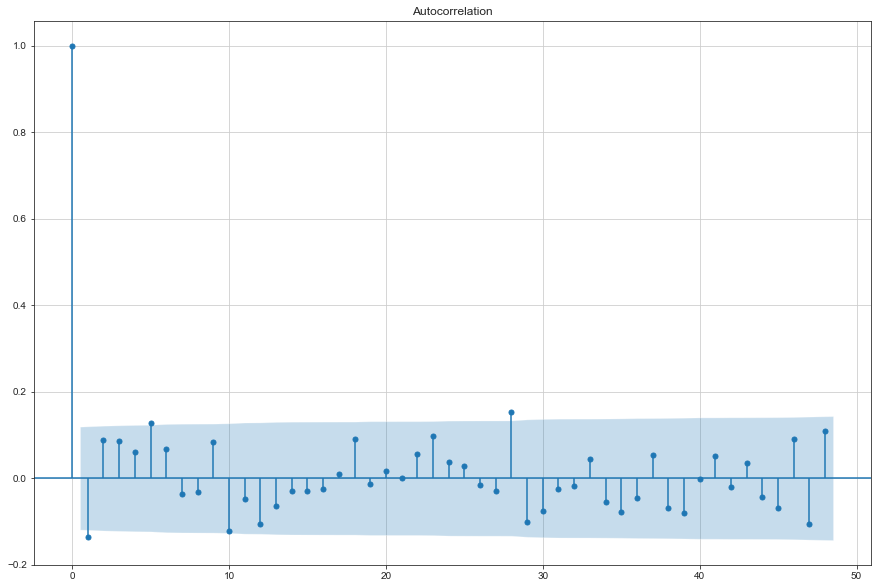

In [51]:
sm.graphics.tsa.plot_acf(data.WAG_C_M_diff.dropna(), lags=48);

По графику автокорреляции определяем q и Q:

Q * S - номер последнего сезонного лага, при котором автокорреляция значима. S = 12, **Q = 0**, т.к. значимых сезонных лагов нет.

Параметр q задаётся номером последнего несезонного лага, при котором автокорреляция значима, **q = 1**.

### Частичная автокорреляция

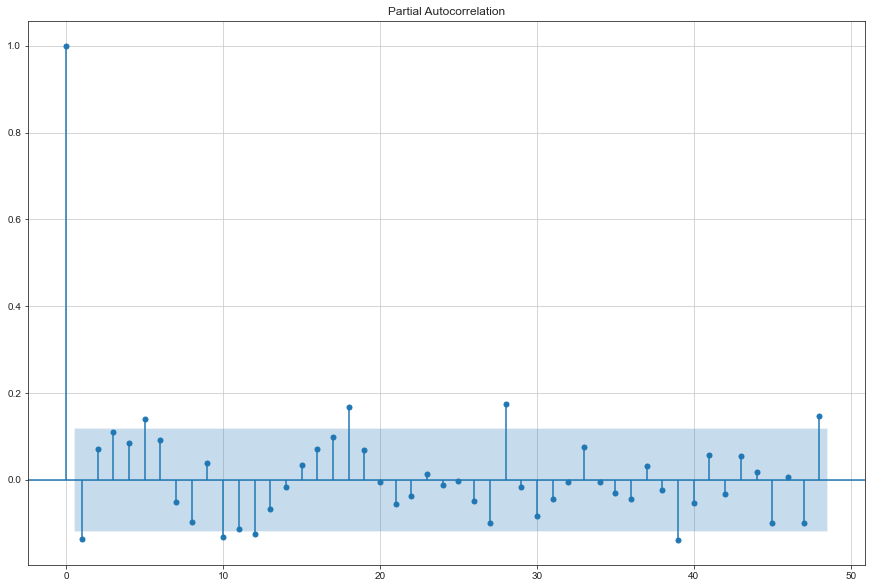

In [52]:
sm.graphics.tsa.plot_pacf(data.WAG_C_M_diff.dropna(), lags=48);

По графику частичной автокорреляции определяем начальное приближение для p и P:

Начальное приближение для параметра P * S задаёт номер последнего сезонного лага, при котором частичная автокорреляция значима. S = 12, P = 4 - при таком значении получается слишком много моделей (200) 

p.s. время обработки примерно 14 минут на Mac M1

возьмём **P = 1**.

p задаётся как номер последнего несезонного лага, при котором частичная автокорреляция значима. В первом приблежении p < 12, тогда p = 10. 

Затем, пробуя менять значения (p=18..28), выяснилось, что при поиске от 0 до **p=18**, получается лучшая модель с меньшим aic.

In [53]:
p = 18
P = 1
q = 1
Q = 0
d = 1
D = 1
s = 12

ps = range(0, p + 1)
Ps = range(0, P + 1)
qs = range(0, q + 1)
Qs = range(0, Q + 1)

Параметры, на которых будет обучаться модель:

In [54]:
parameters = product(ps, qs, Ps, [0])
parameters_list = list(parameters)
print(f'Всего моделей: {len(parameters_list)}')

Всего моделей: 76


Обучаем модель:

In [55]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_boxed, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (12, 0, 1, 0)
wrong parameters: (12, 1, 1, 0)
wrong parameters: (13, 0, 1, 0)
wrong parameters: (13, 1, 1, 0)
wrong parameters: (14, 0, 1, 0)
wrong parameters: (14, 1, 1, 0)
wrong parameters: (15, 0, 1, 0)
wrong parameters: (15, 1, 1, 0)
wrong parameters: (16, 0, 1, 0)
wrong parameters: (16, 1, 1, 0)
wrong parameters: (17, 0, 1, 0)
wrong parameters: (17, 1, 1, 0)
wrong parameters: (18, 0, 1, 0)
wrong parameters: (18, 1, 1, 0)


10 первых моделей:

In [56]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
45,"(11, 0, 1, 0)",-9.662085
47,"(11, 1, 1, 0)",-9.509324
60,"(18, 0, 0, 0)",-8.464590
61,"(18, 1, 0, 0)",-7.687089
25,"(6, 0, 1, 0)",-7.552970


Лучшая модель:

In [57]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       WAG_C_M_boxed   No. Observations:                  284
Model:             SARIMAX(11, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  17.831
Date:                             Wed, 16 Feb 2022   AIC                             -9.662
Time:                                     17:19:31   BIC                             37.165
Sample:                                 01-01-1993   HQIC                             9.140
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      0.048     -4.566      0.000      -0.311      -0.124
ar.L2          0.0205      0.070      0.295      0.768      -0.116       0.157
ar.L3          0.1070      0.065      1.650      0.099      -0.020       0.234
ar.L4          0.1340      0.077      1.746      0.081      -0.016       0.284
ar.L5          0.2327      0.076      3.062      0.002       0.084       0.382
ar.L6          0.1935      0.079      2.458      0.014       0.039       0.348
ar.L7          0.0201      0.089      0.225      0.822      -0.155       0.195
ar.L8         -0.0440      0.086     -0.511      0.610      -0.213       0.125
ar.L9          0.0217      0.075      0.290      0.772      -0.125       0.168
ar.L10        -0.1542      0.073     -2.121      0.034      -0.297      -0.012
ar.L11        -0.1618      0.059     -2.761      0.006      -0.277      -0.047
ar.S.L12      -0.2084      0.056     -3.737      0.000      -0.318      -0.099
sigma2         0.0511      0.004     13.574      0.000       0.044       0.058
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                42.85
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.28
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
res = best_model.resid.dropna()

H0 - среднее в генеральной совокупности равно нулю

H1 - не равно

Найдём вероятность получить такие значения при верности нулевой гипотезы:

In [59]:
print(f'Критерий Стьюдента для остатков: {stats.ttest_1samp(res, 0).pvalue}')

Критерий Стьюдента для остатков: 0.7032687720143629


Согласно полученному значению p-value, нулевую гипотезу не отклоняем.

Проверим ряд на стационарность:

H0 - ряд не стационарен

H1 - стационарен

In [60]:
sm.tsa.stattools.adfuller(res)[1]

0.0

С большой уверенностью можно говорить о том, что ряд стационарен.

Нарисуем графики остатков и автокоррлированности для них:

<AxesSubplot:xlabel='month'>

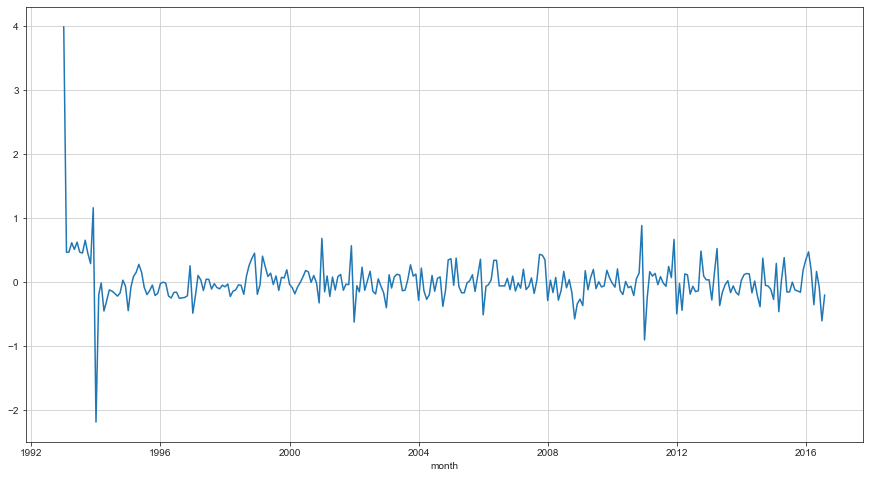

In [61]:
sns.lineplot(x=res.index, y=res.values,figure=figsize(15, 8))

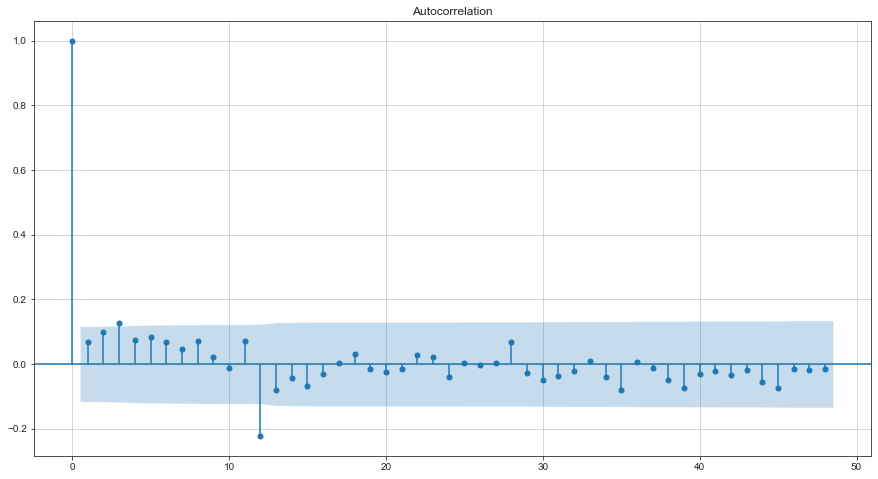

In [62]:
sm.graphics.tsa.plot_acf(res, lags=48, figure=figsize(15, 8));

Обратное преобразование Бокса-Кокса:

In [63]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [64]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

Сравним значения модели и реальные данные:

<AxesSubplot:xlabel='month'>

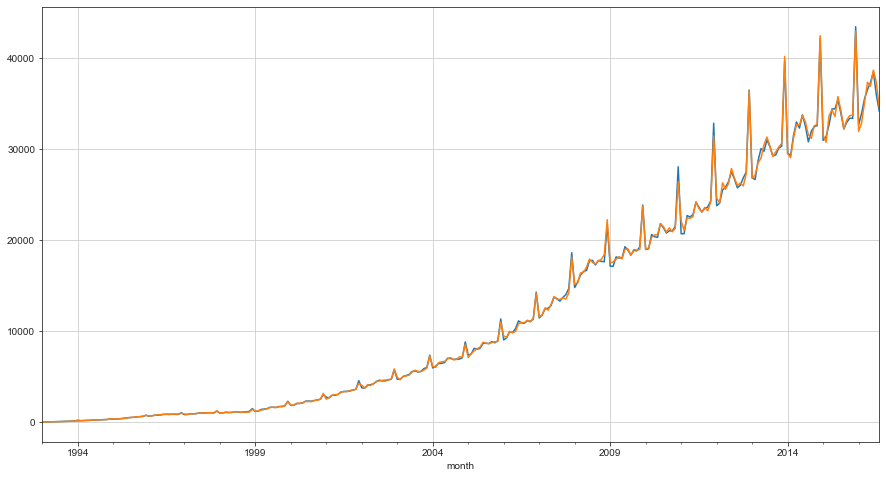

In [65]:
data.WAG_C_M.plot()
data.model.plot()

## Прогноз

In [66]:
salary = data.WAG_C_M.to_frame()

In [67]:
data[-1:].index[0].date()

datetime.date(2016, 8, 1)

In [68]:
date_list = [data[-1:].index[0].date()+ relativedelta(months=x) for x in range(0,36)]

In [69]:
#элемент, с которого начнётся прогноз(если загрузить, например, данные за этот год, это значение поменяется.
start = sum(salary.WAG_C_M.isna() == False)
end = 320

In [70]:
future = pd.DataFrame(index=date_list, columns=salary.columns)
salary = pd.concat([salary, future])
# -2 для того, чтобы не было разрыва
salary['forecast'] = invboxcox(best_model.predict(start=start - 2, end=end), lmbda)

/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing
/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing


<AxesSubplot:xlabel='Year', ylabel='Salary'>

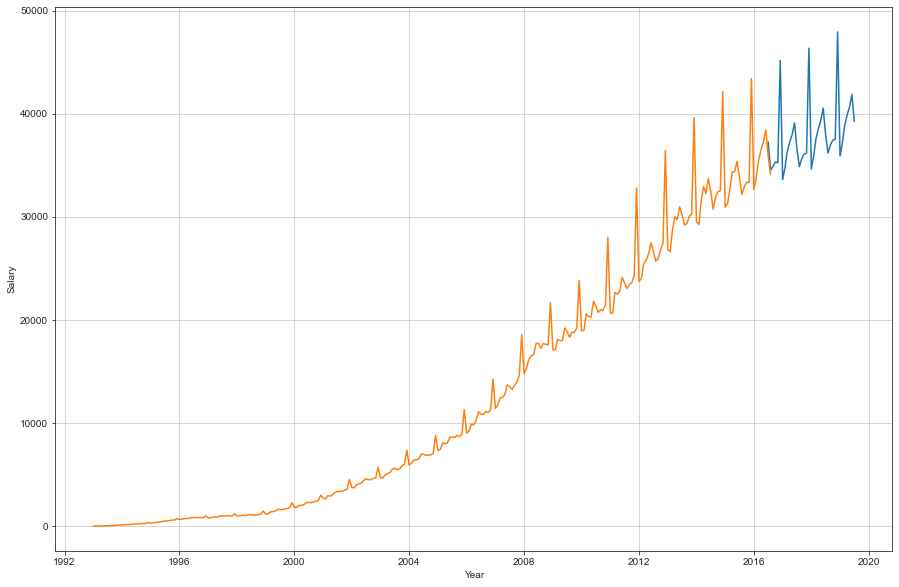

In [71]:
salary.forecast.plot(figure=figsize(15, 10), xlabel='Year', ylabel='Salary')
salary.WAG_C_M.plot()